In [11]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

from os import P_ALL
from scipy.sparse import csr_matrix


![william-shakespeare-black-silhouette.png](attachment:william-shakespeare-black-silhouette.png)

## Problem One: Exploring Shakespeare's Plays with PCA 

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem.



### Part A:  Reading and exploring the data

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken:

![Screenshot%202023-10-14%20at%208.17.27%20AM.png](attachment:Screenshot%202023-10-14%20at%208.17.27%20AM.png)


2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file.


![Screenshot%202023-10-14%20at%208.39.25%20AM.png](attachment:Screenshot%202023-10-14%20at%208.39.25%20AM.png)


3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second.



![Screenshot%202023-10-14%20at%208.26.26%20AM.png](attachment:Screenshot%202023-10-14%20at%208.26.26%20AM.png)

**To Do:**   For each of the arrays, print out the the `shape` and the first line.


In [12]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()


In [13]:
print(plays_array.shape)
print(plays_array[0],"\n")

print(player_genders_array.shape)
print(player_genders_array[0],"\n")

print(play_attributes_array.shape)
print(play_attributes_array[0])

(111582, 4)
[1 'Henry IV Part 1' '<Stage Direction>' 'ACT I'] 

(398, 2)
['AARON' 'male'] 

(36, 3)
['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step.

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly.

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`).


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


In [14]:
# create a dict with play names as keys and concatenate all lines into a single string for that play's value

play_lines = defaultdict(lambda: '')

for (_,pn,pr,ln) in plays_array:
  if pr == '<Stage Direction>':
    continue
  play_lines[pn] += ln + ' '


# now use the dictionary to create an array with 36 rows and 1 column, containing all the strings, in the SAME ORDER as in the play_attributes array
play_names = list(play_lines.keys())
play_strings = list(play_lines.values())
# Arranging the play lines according to playy_attributes array
play_strings_array = [play_lines[play_name] for play_name in play_attributes_array[:, 0]]
print(len(play_strings_array))



36


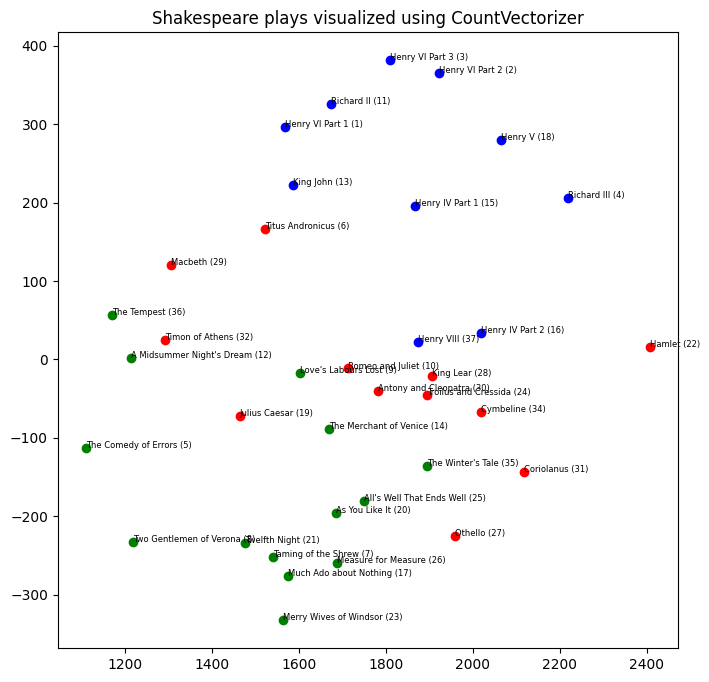

In [15]:
play_names = play_attributes_array[:, 0]
genres = play_attributes_array[:, 1]
chronological_order = play_attributes_array[:, 2]

vectorizer = CountVectorizer()
# Note that play_strings_array has the play lines in order of the play names in play_attributes
doc_word_matrix = vectorizer.fit_transform(play_strings_array)

pca = TruncatedSVD(n_components=2)
result = pca.fit_transform(doc_word_matrix)

color_dict = {'History': 'blue', 'Comedy': 'green', 'Tragedy': 'red'}
plt.figure(figsize=(8, 8))
for i, (name, genre, order) in enumerate(zip(play_names, genres, chronological_order)):
    plt.scatter(result[i, 0], result[i, 1], color=color_dict[genre])
    plt.annotate(f'{name} ({order})', xy=(result[i, 0], result[i, 1]), fontsize=6)
plt.title('Shakespeare plays visualized using CountVectorizer')
plt.show()



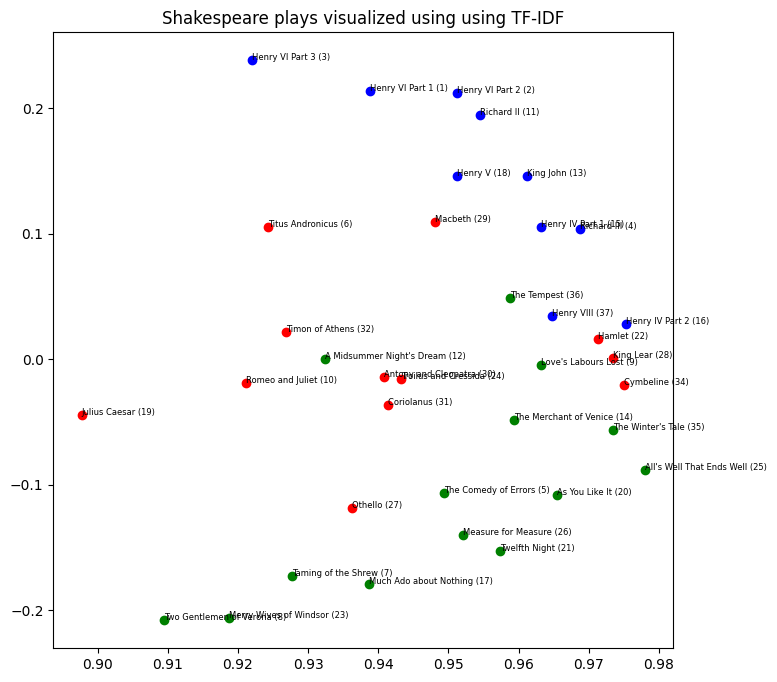

In [17]:
vectorizer_tfidf = TfidfVectorizer()
doc_word_matrix_tfidf = vectorizer_tfidf.fit_transform(play_strings_array)

pca_tfidf = TruncatedSVD(n_components=2)
result_tfidf = pca_tfidf.fit_transform(doc_word_matrix_tfidf)

plt.figure(figsize=(8, 8))
for i, (name, genre, order) in enumerate(zip(play_names, genres, chronological_order)):
    plt.scatter(result_tfidf[i, 0], result_tfidf[i, 1], color=color_dict[genre])
    plt.annotate(f'{name} ({order})', xy=(result_tfidf[i, 0], result_tfidf[i, 1]), fontsize=6)

plt.title('Shakespeare plays visualized using using TF-IDF')
plt.show()

5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?

The plays that are plotted close to each other are the ones that are most similar to each other.

The plays marked as Histories are mostly away from the other two categories. Whereas, tragedies and comedies seem to have some level of similarity.

The blue of the history genre indicates that Henry VII and Henry IV Part 2 are outliers. Hamlet appears to be an outlier in Count Vectorizer but not in TF-IDF.Julius Ceaser appears to be an outlier in TF-IDF but not Count Vectorizer. Macbeth and Titus Andronicus appear to be outliers too.

Although the plot seems to have changed, the plays are mostly grouped together(same order) in both the plots and provide similar insights.

![Screenshot%202023-10-14%20at%209.09.20%20AM.png](attachment:Screenshot%202023-10-14%20at%209.09.20%20AM.png)

### Part C: Visualizing the Players

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe (it will not be as satisfying as the previous part).

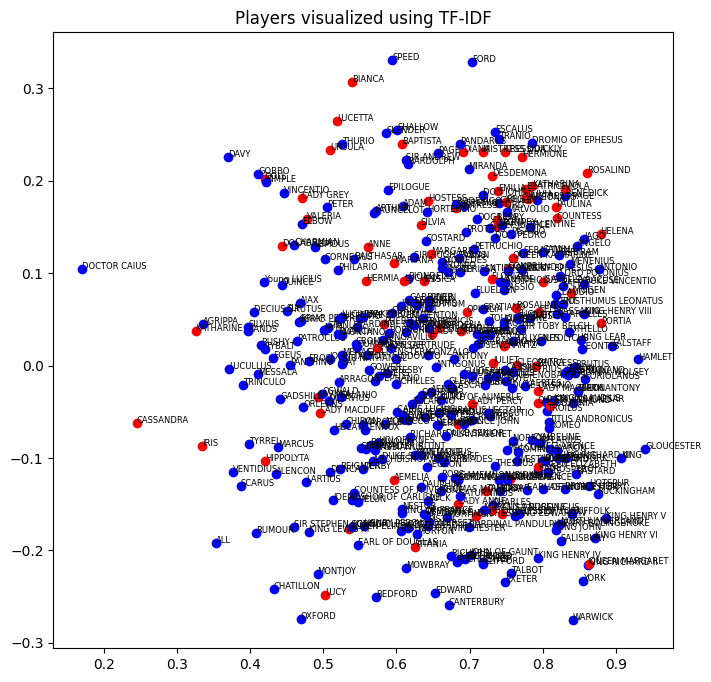

In [18]:
player_lines = defaultdict(lambda: '')

for (_, play_name, pr, ln) in plays_array:
    if pr == '<Stage Direction>':
        continue
    player_lines[pr] += ln + ' '

player_names = list(player_lines.keys())
#Sorting the player lines dictionary in order of the player name as ordered in the player_genders array
player_strings_array = [player_lines[pr] for pr in player_genders_array[:, 0]]

vectorizer_players = TfidfVectorizer()
doc_word_matrix_players = vectorizer_players.fit_transform(player_strings_array)

pca_players = TruncatedSVD(n_components=2)
result_players = pca_players.fit_transform(doc_word_matrix_players)

color_dict_gender = {'male': 'blue', 'female': 'red'}
plt.figure(figsize=(8, 8))
for i, (name, gender) in enumerate(zip(player_genders_array[:, 0],player_genders_array[:, 1])):
    plt.scatter(result_players[i, 0], result_players[i, 1], color=color_dict_gender[gender])
    plt.annotate(name, xy=(result_players[i, 0], result_players[i, 1]), fontsize=6)

plt.title('Players visualized using TF-IDF')
plt.show()



Since we are visualizing the characters with the words they are speaking, there is not much difference in what male and female characters speak.

There are a few outliers like Doctor Caius and Cassandra.



### Part D:  DIY Word Embeddings 

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play.

Display the plays using `TruncatedSVD` as you did previously.  

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes.
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`.
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary.


word-word matrix: 100%|██████████| 36/36 [41:19<00:00, 68.86s/it]


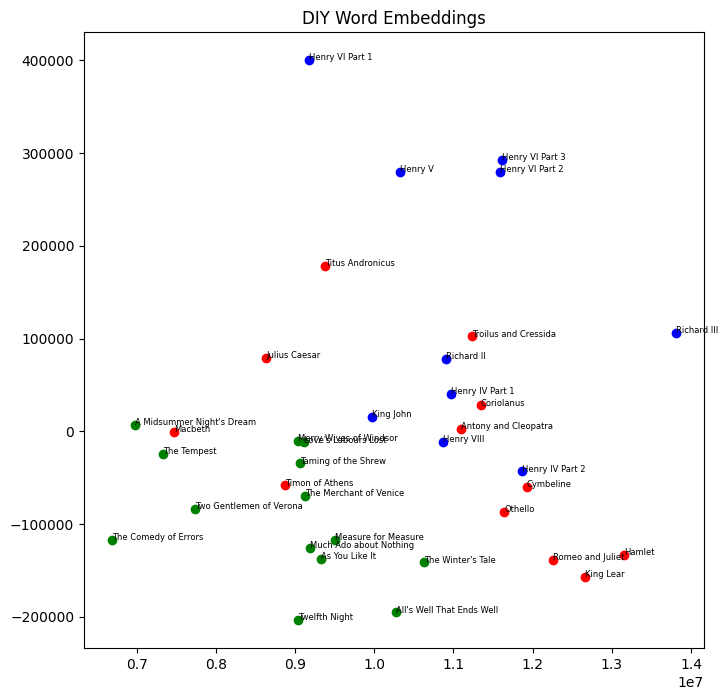

In [26]:

counts = Counter(w for words in play_lines.values() for w in re.sub(r'[.,;:?!]', '', words.lower()).split())
fivek_common_words = [w for w, _ in counts.most_common(5000)]

lines_dict = {}
# Cleaning the line by removing special characters and converting to lowercase
for pn, ln in tqdm(play_lines.items(), desc = "Processing play lines"):
    words = re.sub(r'[.,;:?!]', '', ln.lower()).split()
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if w in fivek_common_words]
    lines_dict[pn] = " ".join(words)

d, row_i, col_i= [], [], []
w_idx = {word: idx for idx, word in enumerate(fivek_common_words)}

# Creating the word-word matrix
for ln in tqdm(lines_dict.values(), desc = "word-word matrix" ):
    words = ln.split()
    completed = set()
    for i, w1 in enumerate(words):
        for j, w2 in enumerate(words):
            if i != j and w1 in w_idx and w2 in w_idx:
                x, y = w_idx[w1], w_idx[w2]
                if (x, y) not in completed:
                    row_i.append(x)
                    col_i.append(y)
                    d.append(1)
                    completed.add((x, y))


occurrence_matrix = csr_matrix((d, (row_i, col_i)), shape=(len(fivek_common_words), len(fivek_common_words)))

occurrence_matrix = occurrence_matrix + occurrence_matrix.T - csr_matrix.diagonal(occurrence_matrix)

# Creating the average document-term matrix
p_vectors = []
for play, words in lines_dict.items():
    word_indices = [w_idx[word] for word in words.split() if word in w_idx]
    if len(word_indices) == 0:
        p_vector = np.zeros((len(fivek_common_words),))
    else:
        p_vector = np.sum(occurrence_matrix[word_indices, :], axis=0)
    p_vectors.append(p_vector)


play_vectors = np.array(p_vectors).squeeze()
document = TruncatedSVD(n_components=2).fit_transform(play_vectors)

colors = {'History': 'blue', 'Comedy': 'green', 'Tragedy': 'red'}

plt.figure(figsize=(8, 8))
for i, play in enumerate(play_names):
    plt.scatter(document[i, 0], document[i, 1], marker='o', c=colors.get(play_attributes_array[i][1]))
    plt.text(document[i, 0], document[i,1], play, fontsize=6)
plt.title("DIY Word Embeddings")
plt.show()


It is close to the visualisations provided by TF-IDF but still quite different. The History and Tragedy play seems to have a lot of similarities as they are very close to each other, whereas the TF-IDF does a better job of keeping rhe genres distinct. Overall, it's doing well but maybe if the stopwords are not removed and we use all the words instead of just 5,000 most common words, we can potentialy see an increase in its accuracy.

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms.

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time.

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results.

Display the plays using `PCA` instead of `TruncatedSVD`.  

Again, comment on what you observe: how different is this from the other visualizations?


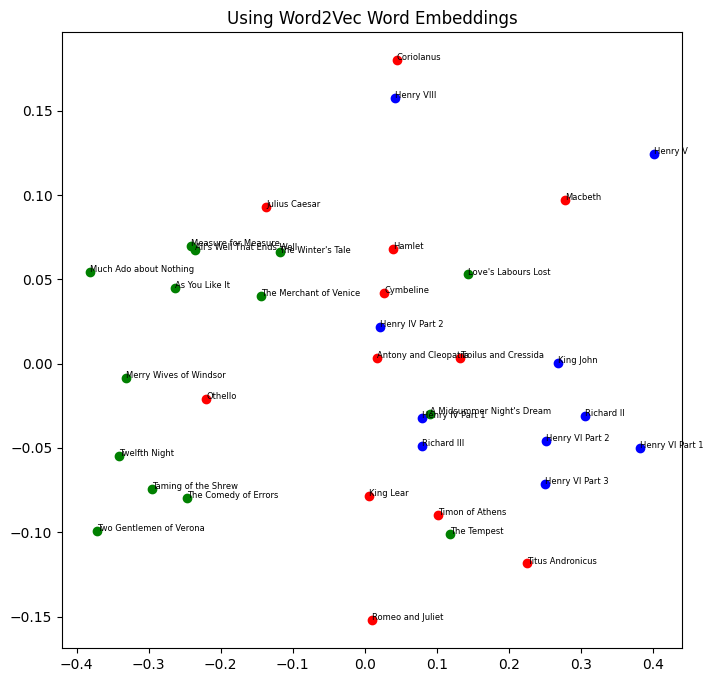

In [46]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

def convert_text(words):
    words = re.sub(r'[.,;:?!]', '', words.lower())
    return words.split()

sentences = [convert_text(line) for line in play_strings]
model = Word2Vec(sentences, window=5, min_count=1)

word_vectors = model.wv

# function to represent a play using averaged word vectors
vectors = []
for token in sentences:
    token = [word for word in token if word in word_vectors]
    doc_vector = sum(word_vectors[term] for term in token) / len(token)
    vectors.append(doc_vector)

play_vectors = PCA(n_components=2)
result_vectors = play_vectors.fit_transform(vectors)

plt.figure(figsize=(8, 8))
for i, play in enumerate(play_names):
    plt.scatter(result_vectors[i, 0], result_vectors[i, 1], c= color_dict.get(play_attributes_array[i][1]))
    plt.annotate(play, (result_vectors[i, 0], result_vectors[i, 1]), fontsize=6)
plt.title("Using Word2Vec Word Embeddings")
plt.show()


This plot indicates that this method of using word2vec for plays seems to have many outliers.

### Part F:  Visualizing the Players using Word2Vec Word Embeddings 

Now you must repeat Part C, but using these `Word2Vec` embeddings.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe. How is this different from what you saw in Part C?


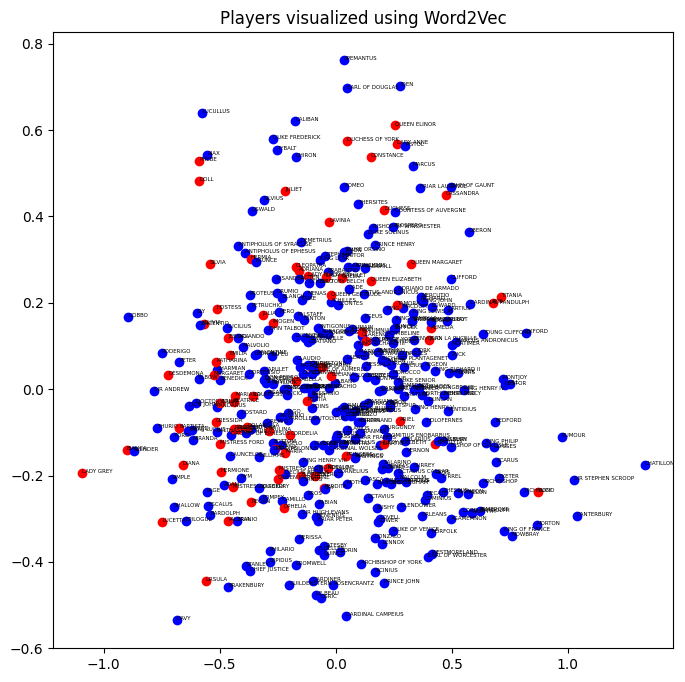

In [64]:
color_dict_gender = {'male': 'blue', 'female': 'red'}

def convert_text(words):
    words = re.sub(r'[.,;:?!]', '', words.lower())
    return words.split()

players_sentences = [convert_text(line) for line in player_strings_array]
model = Word2Vec(players_sentences, window=5, min_count=3)
word_vectors_players = model.wv

document_vectors_players = []
for line in players_sentences:
    line = [word for word in line if word in word_vectors_players]
    line_vector = sum(word_vectors_players[term] for term in line) / len(line)
    document_vectors_players.append(line_vector)

pca_players_word2vec = PCA(n_components=2)
result_players_word2vec = pca_players_word2vec.fit_transform(document_vectors_players)

plt.figure(figsize=(8, 8))
for i, (name, gender) in enumerate(zip(player_genders_array[:, 0], player_genders_array[:, 1])):
    plt.scatter(result_players_word2vec[i, 0], result_players_word2vec[i, 1], color=color_dict_gender[gender])
    plt.annotate(name, xy=(result_players_word2vec[i, 0], result_players_word2vec[i, 1]), fontsize=4)
plt.title('Players visualized using Word2Vec')
plt.show()


Most of the players lines seem to be seem to be similar with each other, shown by the close grouping of points. 1.C) using TF-IDF, seems to have words more correlated and hence may be a better vector representation, with a higher degree of similarity.

## Problem Two: Classifying Text with a Feed-Forward Neural Network 


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data 

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'.
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings.


### Part B: Create the DataLoader 

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64.



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step.
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

#https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float32)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_embedding = load_glove_model('/content/drive/MyDrive/Colab_Notebooks/glove.6B.100d.txt')

Loading Glove Model
400000 words loaded!


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/enron_spam_ham.csv')
message_vectors = []

for text in tqdm(df['Message'], desc='Processing Messages'):
    words = nlp(text)
    vectors = []
    for word in words:
        if str(word) in glove_embedding:
            vectors.append(glove_embedding[str(word)])
    if len(vectors) > 0:
        message_vector = np.mean(vectors, axis=0)
        message_vectors.append(message_vector)
    else:
        message_vectors.append(np.zeros(100,))

message_avg_vectors = np.array(message_vectors)

Processing Messages: 100%|██████████| 28138/28138 [24:52<00:00, 18.86it/s]


In [73]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class EmailDataset(Dataset):
    def __init__(self, message_vectors, labels):
        self.message_vectors = message_vectors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        message_vec = torch.tensor(self.message_vectors[idx]).float()
        label = torch.tensor(self.labels[idx])
        return message_vec, label

labels = df['Spam'].values

data = EmailDataset(message_avg_vectors, labels)

X_train, X_temp, y_train, y_temp = train_test_split(message_avg_vectors, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = EmailDataset(X_train, y_train)
val_dataset = EmailDataset(X_val, y_val)
test_dataset = EmailDataset(X_test, y_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Part C:  Build the neural net model 

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this.

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit.

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test.

In [81]:

class modelffn(nn.Module):
    def __init__(self):
        super(modelffn, self).__init__()
        self.fc1 = nn.Linear(100, 15)
        self.fc2 = nn.Linear(15,2)
        self.relu = nn.ReLU()
        # self.fc3 = nn.Linear(64, 32)
        # self.fc4 = nn.Linear(32, 10)
        # self.fc5 = nn.Linear(10, 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        # out = self.relu(out)
        # out = self.fc5(out)
        return out

learning_rate = 0.003
num_epochs = 30

model = modelffn()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


training_losses = []
training_accuracies = []

val_losses = []
val_accuracies = []

# Training the model with early stopping
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    total_correct = 0
    total_samples = 0
    ### TRAINING
    for train_data, train_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = loss_fn(outputs, train_labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += train_labels.size(0)
        total_correct += (predicted == train_labels).sum().item()

    training_losses.append(training_loss/ total_samples)
    train_accuracy = total_correct / total_samples
    training_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_samples = 0
    ### VALIDATION
    with torch.no_grad():
        for val_data, val_labels in val_loader:
            outputs = model(val_data)
            val_loss += loss_fn(outputs, val_labels)
            _, predicted = torch.max(outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()

    val_losses.append(val_loss / total_samples)
    val_accuracy = total_correct / total_samples
    val_accuracies.append(val_accuracy)

    #early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
    else:
        break

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")



torch.save(best_model, 'best_model.pth')
# Getting the model with the least validation loss
model.load_state_dict(torch.load('best_model.pth'))
### TESTING
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy}')



Epoch [1/30], Train Accuracy: 0.8386939138160817, Validation Accuracy: 0.9235963041933192
Epoch [2/30], Train Accuracy: 0.9266992447800977, Validation Accuracy: 0.9402985074626866
Epoch [3/30], Train Accuracy: 0.9362949800088849, Validation Accuracy: 0.9431414356787491
Epoch [4/30], Train Accuracy: 0.9401599289204798, Validation Accuracy: 0.9463397299218195
Epoch [5/30], Train Accuracy: 0.9422478898267437, Validation Accuracy: 0.9498933901918977
Epoch [6/30], Train Accuracy: 0.9441137272323412, Validation Accuracy: 0.9527363184079602
Epoch [7/30], Train Accuracy: 0.9458462905375389, Validation Accuracy: 0.9538024164889837
Epoch [8/30], Train Accuracy: 0.9475344291426033, Validation Accuracy: 0.9541577825159915
Epoch [9/30], Train Accuracy: 0.9483340737450022, Validation Accuracy: 0.9552238805970149
Epoch [10/30], Train Accuracy: 0.9504220346512661, Validation Accuracy: 0.9552238805970149
Epoch [11/30], Train Accuracy: 0.9515770768547313, Validation Accuracy: 0.9562899786780383
Epoch [1

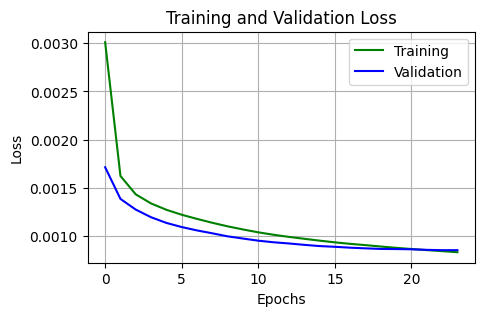

Final Training Loss:   0.000836
Final Validation Loss: 0.000857


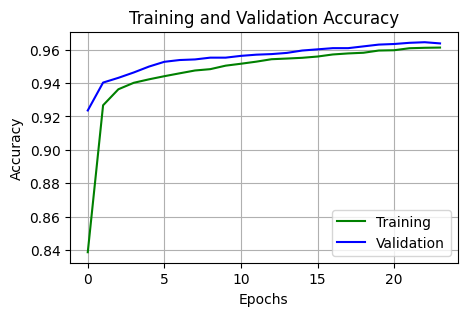

Final Training Accuracy:   0.961262
Final Validation Accuracy: 0.963753

Test Accuracy: 0.9619758351101635



In [82]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):
    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')


    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1].item(),6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", test_accuracy)
    print()


show_performance_curves(training_losses, val_losses, training_accuracies, val_accuracies, test_accuracy)

Observations:

Firstly, the change in architecture did not help the model as it performed a little worse than the linear layer (100,15) and (15,2). Closest to the best accuracies was a model in which the linear layers were (100,64), (64,32), (32,16) and (16,2).

The batch size set to 128 gave the best scores, while 64 was the second best and 256 generating the results with the lowest losses and accuracies.

I used a variety of optimizers, Adagrad for 20 epochs and learning rate of 0.001 resulted in a 0.84 test accuracy, which was very low. SGD for 20 epochs with a lr of 0.001 achieved 0.74 test accuracy. SGD for 20 epochs with a lr of 0.05 achieved 0.94 test accuracy.

Finally, Adams optimizer with a learning rate of 0.003, run for 30 epochs, achieved a test accuracy of 0.96, training accuracy of 0.961 and validation accuracy of 0.963.